<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
         Battery Remaining Useful Life
    </h2>
</div>

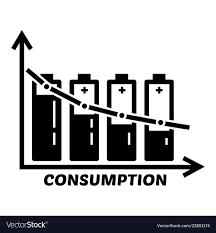

*About Dataset*

The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.
From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.

<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
        Importing the Dependencies
    </h2>
</div>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import LinearSVR
from fancyimpute import IterativeImputer
import regex as re

<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
        Read Data from csv
    </h2>
</div>

In [21]:
data = pd.read_csv("Battery_RUL.csv")
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


**Attribute information**

In [22]:
data.tail()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1
15063,1112.0,677537.27,142740.640000,4.206,3.305,49680.004,599830.14,599830.14,0


<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
        Take a Look at the Data Structure
    </h2>
</div>

In [23]:
data.shape

(15064, 9)

**Note**: **Dataset contains 1509 rows and 9 columns**

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


**All data is in float64 and int64**

In [25]:
data.describe()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


## Checking null values

In [26]:
data.isnull().sum()

Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64

### Dataset is free of null values

<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
        Checking outliers and treating them
    </h2>
</div>

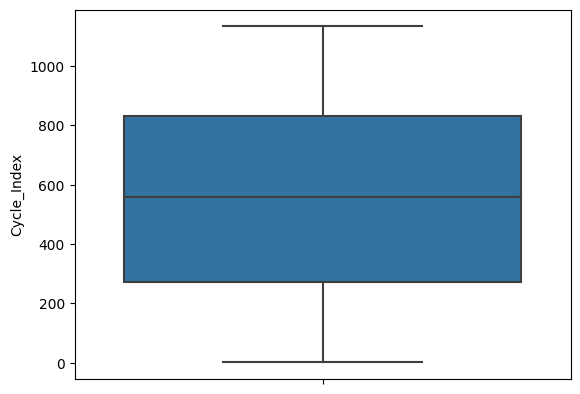

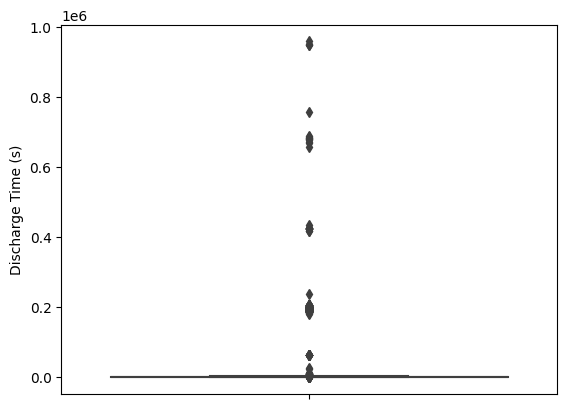

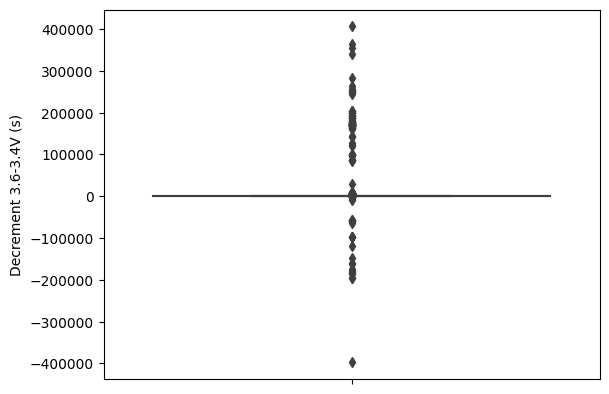

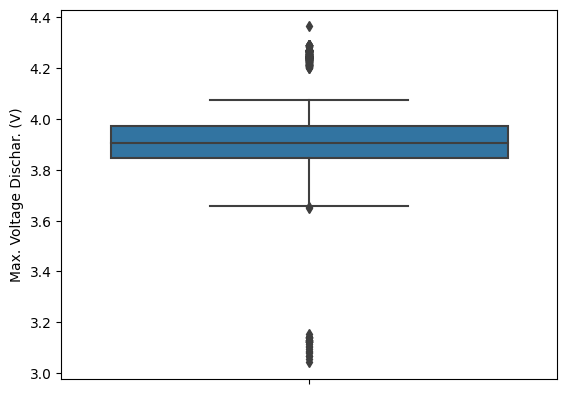

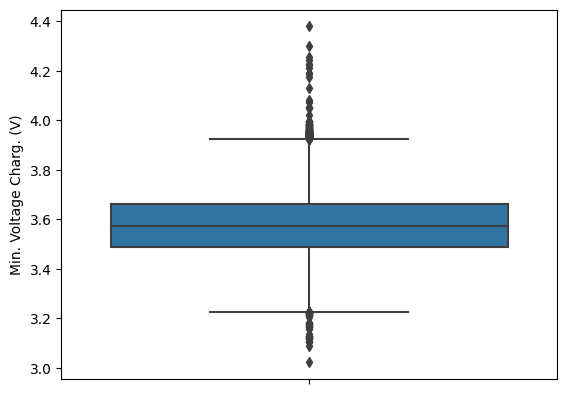

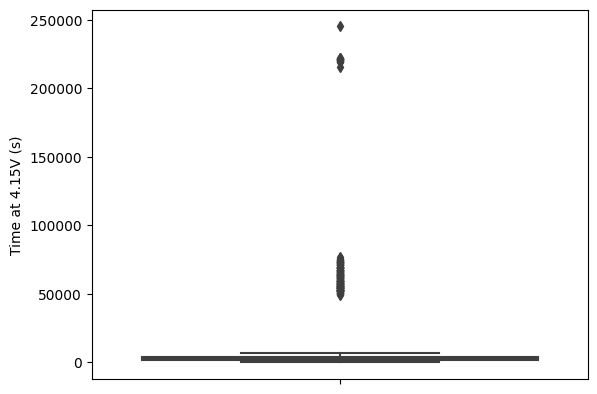

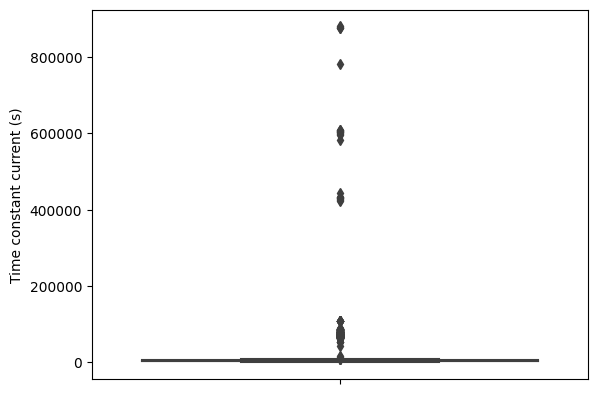

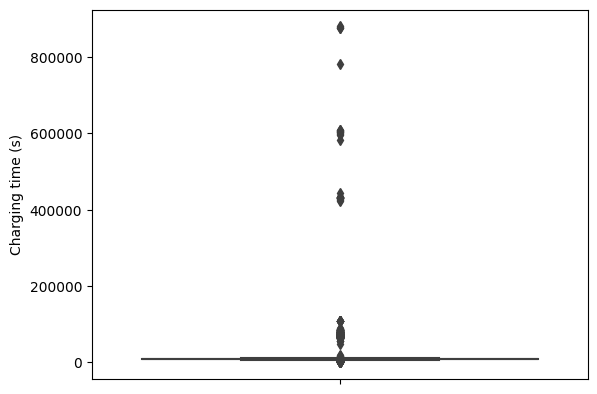

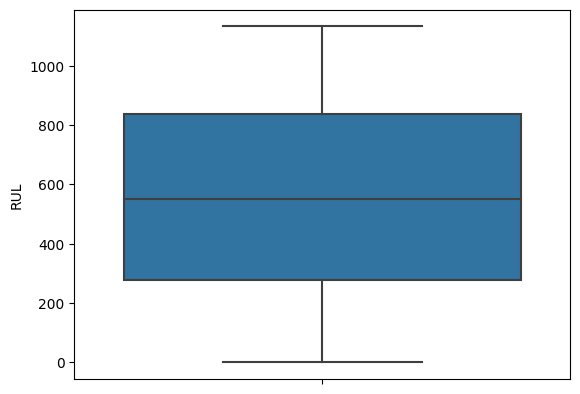

In [27]:
for i in data.columns:
    sns.boxplot(y=data[i])
    plt.show();

## Setting the outlier limits

In [28]:
def outlier_limit(col):
    Q3,Q1 = np.nanpercentile(col, [75,25])
    IQR = Q3- Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL, LL

In [29]:
for i in data.columns:
    UL,LL = outlier_limit(data[i])
    data[i] = np.where((data[i]>UL)|(data[i]<LL), np.nan, data[i])

## Here we treated the outliers and lets plot the barplot again to see the difference

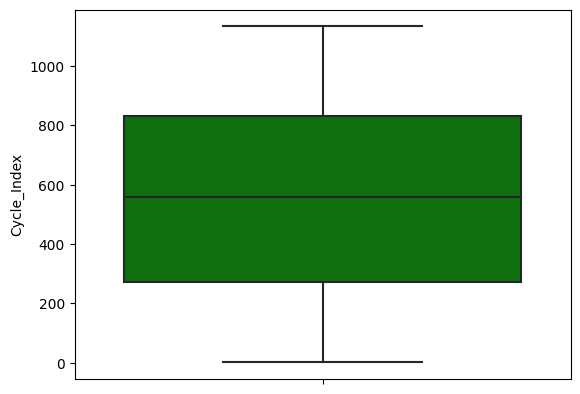

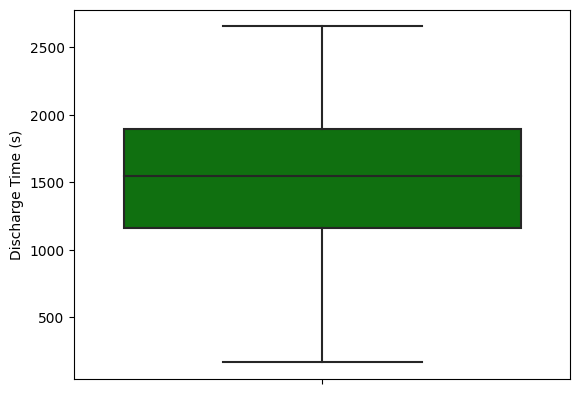

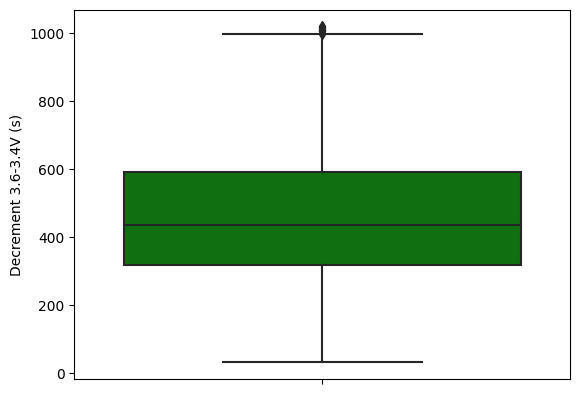

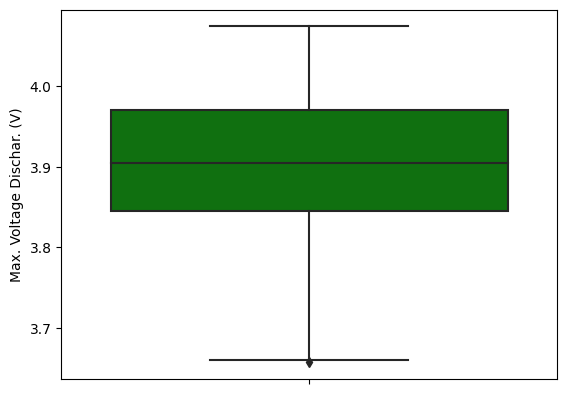

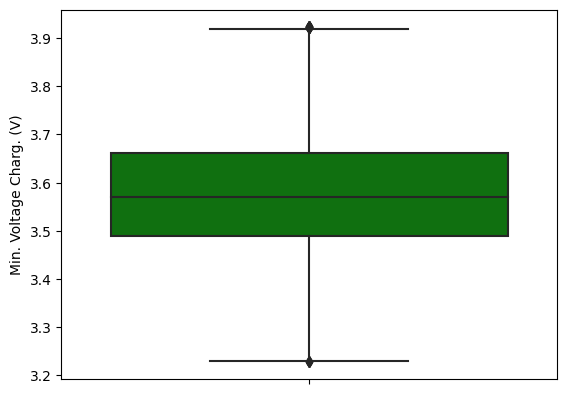

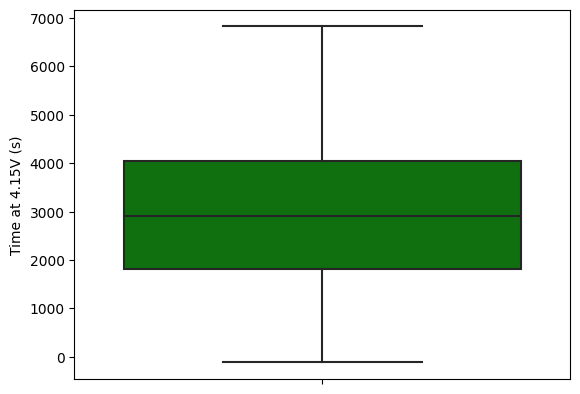

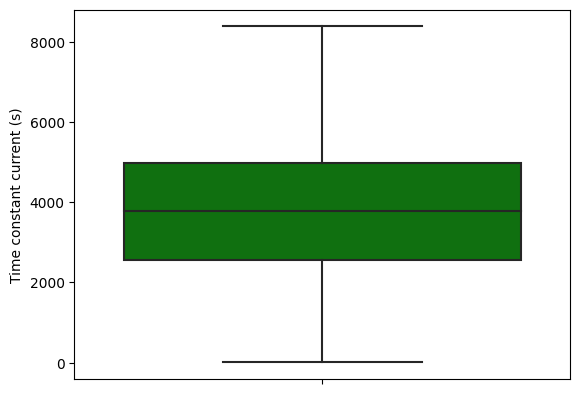

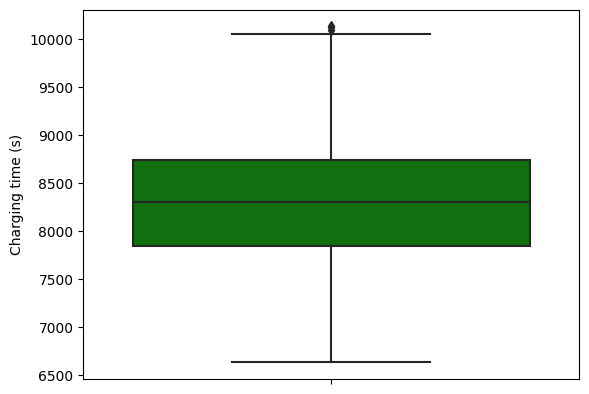

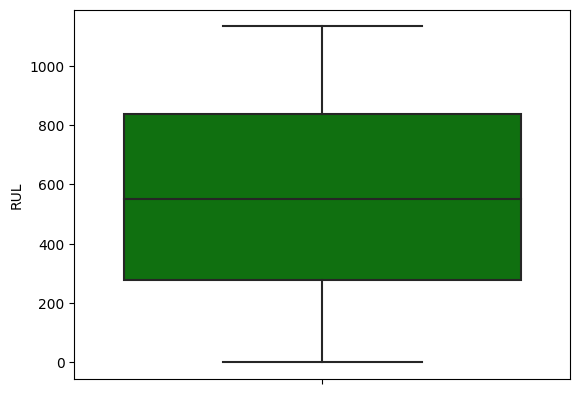

In [30]:
for i in data.columns:
    sns.boxplot(y=data[i],color="green")
    plt.show();

## We have treated the outliers. Lets remove the null values

In [31]:
data.isnull().mean()*100

Cycle_Index                  0.000000
Discharge Time (s)           2.137546
Decrement 3.6-3.4V (s)       1.891928
Max. Voltage Dischar. (V)    1.699416
Min. Voltage Charg. (V)      1.626394
Time at 4.15V (s)            1.108603
Time constant current (s)    1.254647
Charging time (s)            2.954063
RUL                          0.000000
dtype: float64

In [32]:
data.dropna(inplace=True)

In [33]:
data.shape

(14445, 9)

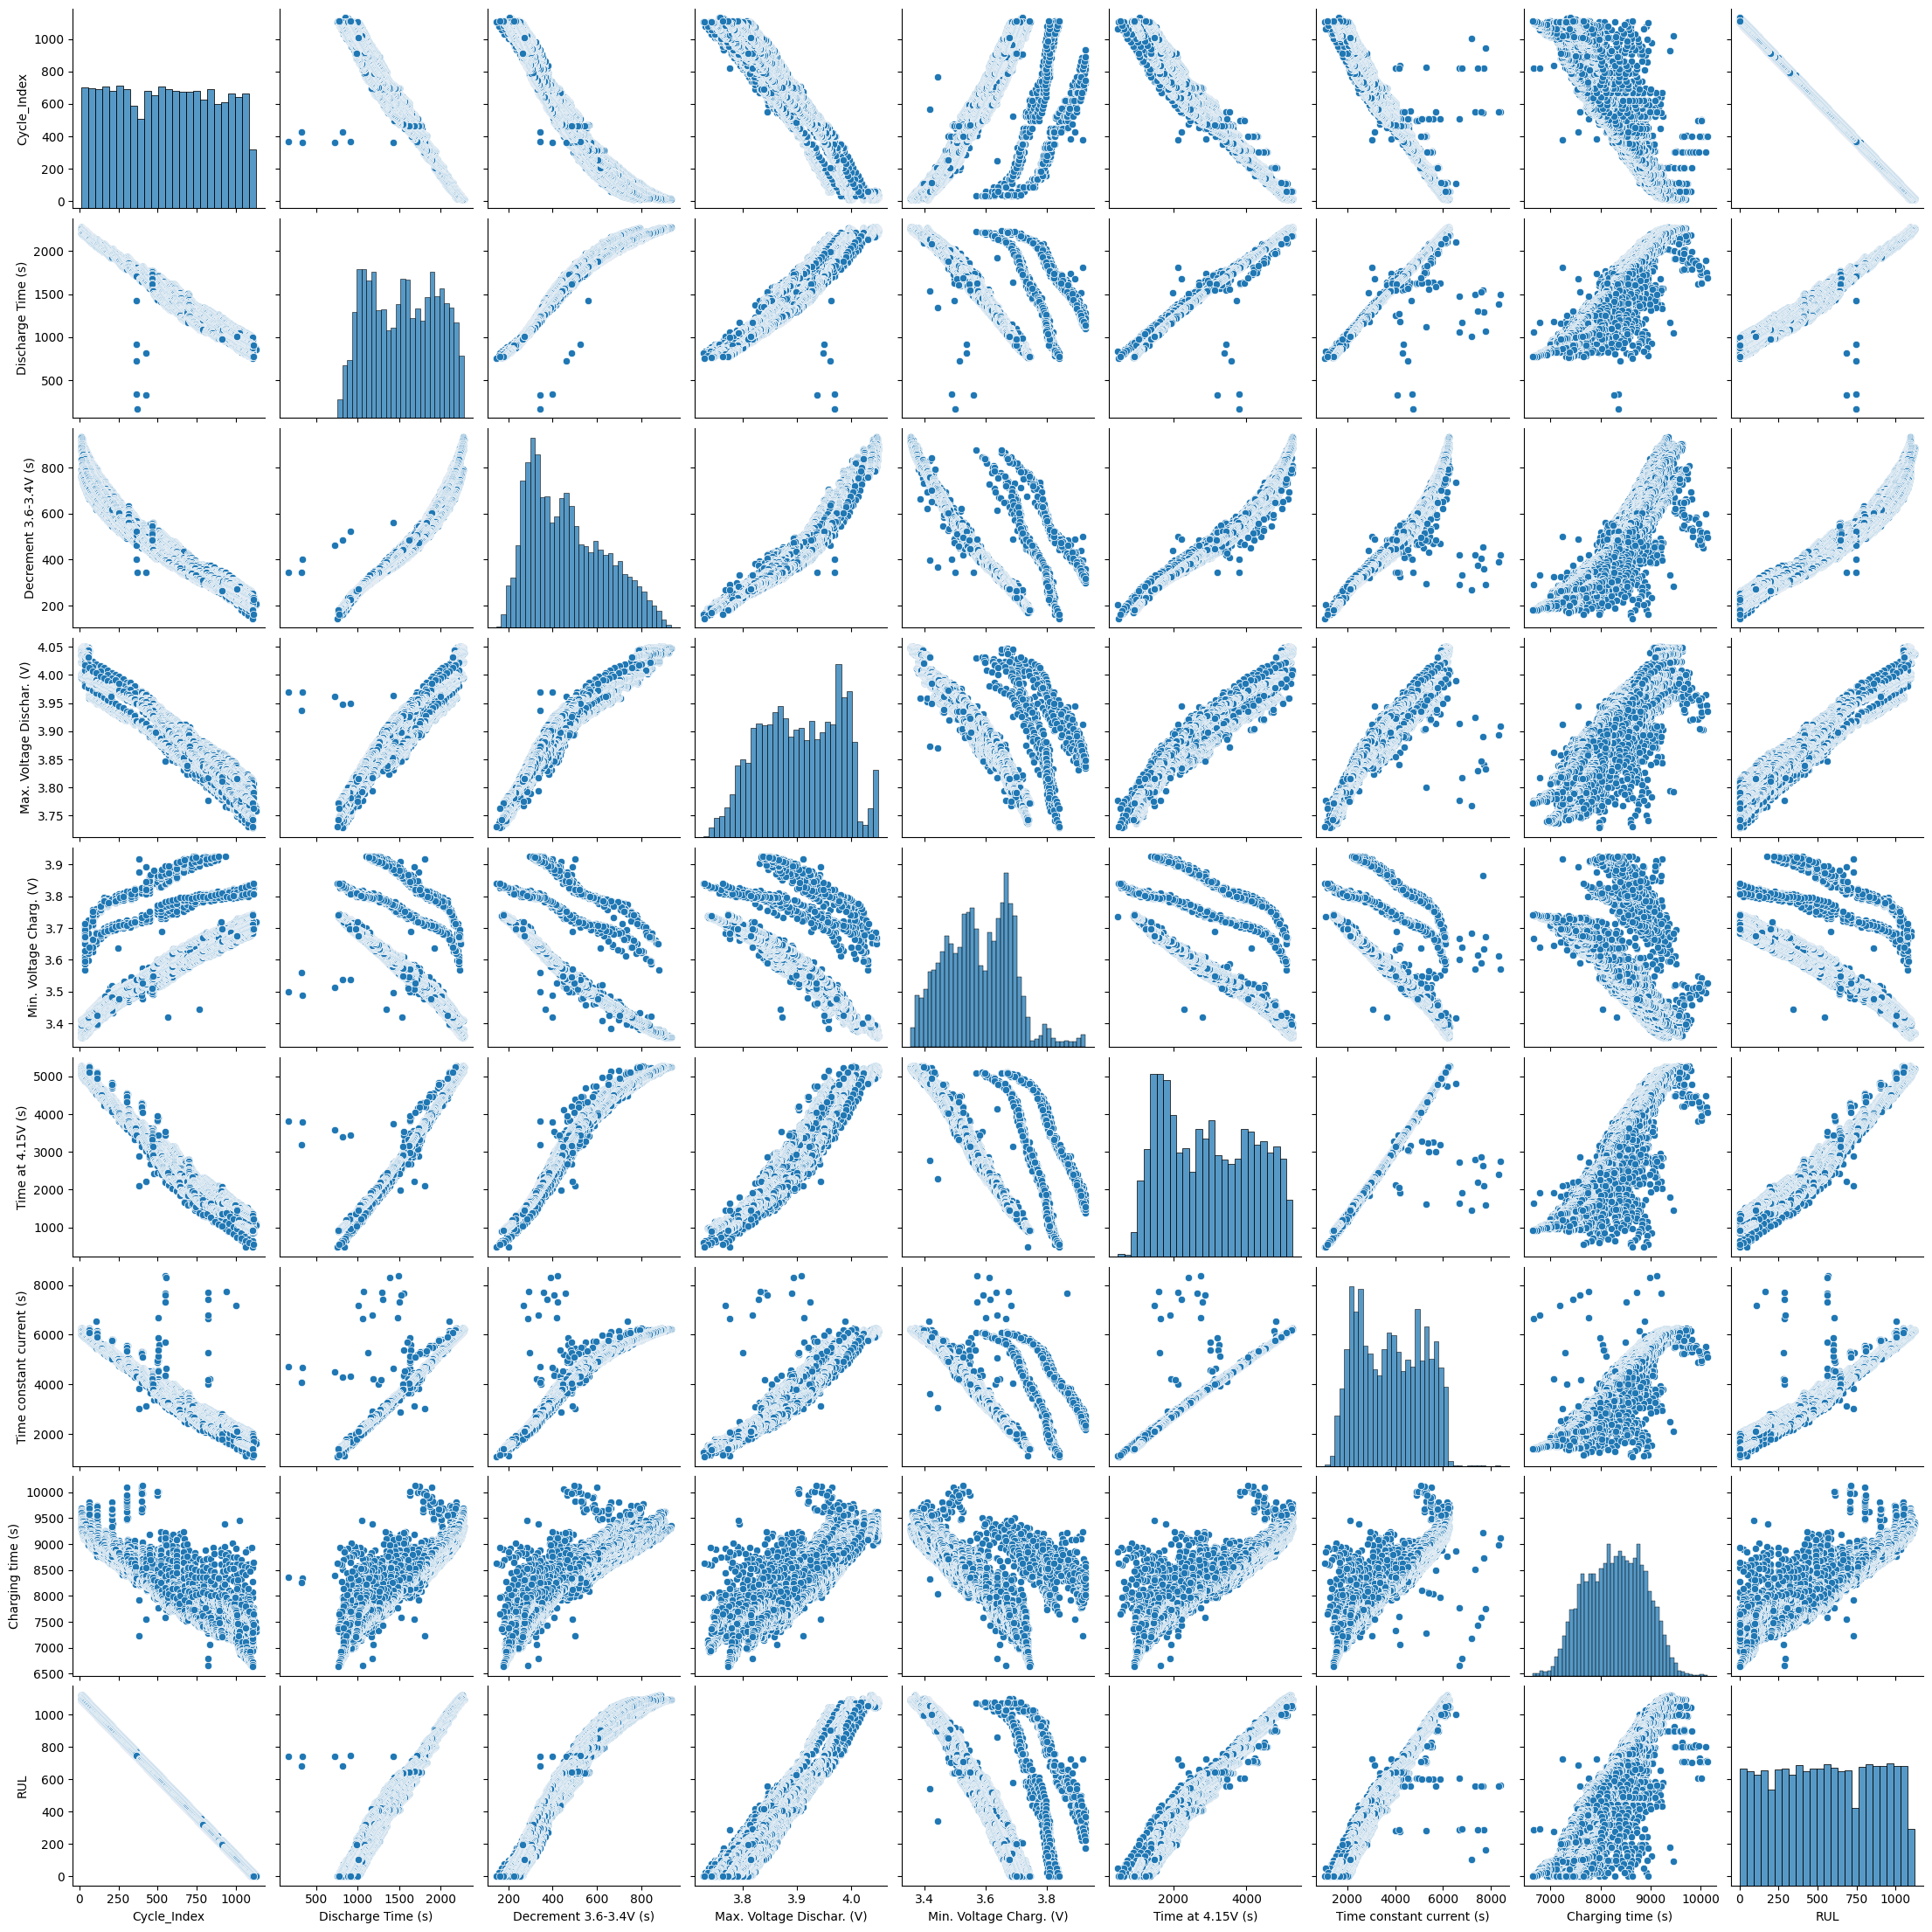

In [34]:
sns.pairplot(data);

<AxesSubplot: >

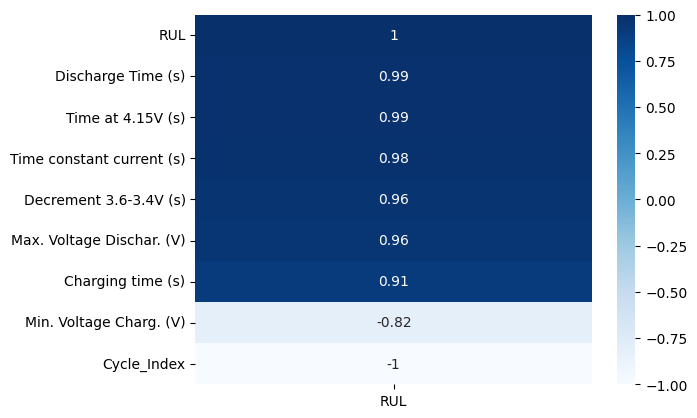

In [35]:
sns.heatmap(data.corr()[["RUL"]].sort_values(by="RUL", ascending=False), vmin=-1, vmax=1,annot=True, cmap="Blues")

In [36]:
data.corr()[['RUL']].sort_values(by='RUL', ascending=False)

,RUL
RUL,1.000000
Discharge Time (s),0.986567
Time at 4.15V (s),0.986203
Time constant current (s),0.983065
Decrement 3.6-3.4V (s),0.964472
Max. Voltage Dischar. (V),0.959805
Charging time (s),0.907941
Min. Voltage Charg. (V),-0.816875
Cycle_Index,-0.999752


#### We can see that except "Cycle_Index" & 'Min. Voltage Charg. (V)' all other features are highly correlated with RUL.

### feature selection

In [37]:
x = data[['Discharge Time (s)', 'Decrement 3.6-3.4V (s)','Max. Voltage Dischar. (V)','Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)']].values

In [38]:
y = data["RUL"].values

##### Scaling the data

In [39]:
sc = StandardScaler()

In [40]:
x = sc.fit_transform(x)

Splitting the data into training and testing data

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [42]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "LinearSVR":LinearSVR(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

In [43]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print("model trained with {}".format(name))
    training_score = model.score(x_train, y_train)*100
    testing_score = model.score(x_test, y_test)*100
    score = r2_score(y_test, model.predict(x_test))*100
    mae = mean_absolute_error(y_test, model.predict(x_test))
    mse = mean_squared_error(y_test, model.predict(x_test))
    rmse = np.sqrt(mse)
    print("r2score: ",score)
    print("training_score: ", training_score)
    print("testing_score: ", testing_score)
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse_test: ", rmse)
    print("*"*100)

model trained with LinearRegression
r2score:  97.7676191647425
training_score:  97.83513827073446
testing_score:  97.7676191647425
mae:  35.52103002645082
mse:  2226.0716747823535
rmse_test:  47.18126402272785
****************************************************************************************************
model trained with Ridge
r2score:  97.76832485346081
training_score:  97.8351176544507
testing_score:  97.76832485346081
mae:  35.526379291553
mse:  2225.36798048331
rmse_test:  47.1738060843442
****************************************************************************************************
model trained with LinearSVR
r2score:  97.73310403551132
training_score:  97.7703579866938
testing_score:  97.73310403551132
mae:  35.5031030563542
mse:  2260.4892572662593
rmse_test:  47.54460281952368
****************************************************************************************************
model trained with DecisionTreeRegressor
r2score:  99.24137934884479
training_score:  99.

#### We can see that RandomForestRegressor is having the best metrics. Lets proceed with it.

#### Since the accuracy is 99% no need for Hyperparameter tuning

In [52]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

In [ ]:
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [01:36<00:18,  1.68s/it]

In [44]:
rfr = RandomForestRegressor(random_state=0)

In [45]:
rfr.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [46]:
y_pred = rfr.predict(x)

In [47]:
OUTPUT = pd.DataFrame(zip(y,y_pred), columns=("ACTUAL", "PREDICTION"))

In [48]:
OUTPUT.head()

,ACTUAL,PREDICTION
0,1095.0,1093.35
1,1094.0,1093.19
2,1093.0,1091.87
3,1092.0,1091.55
4,1091.0,1090.69


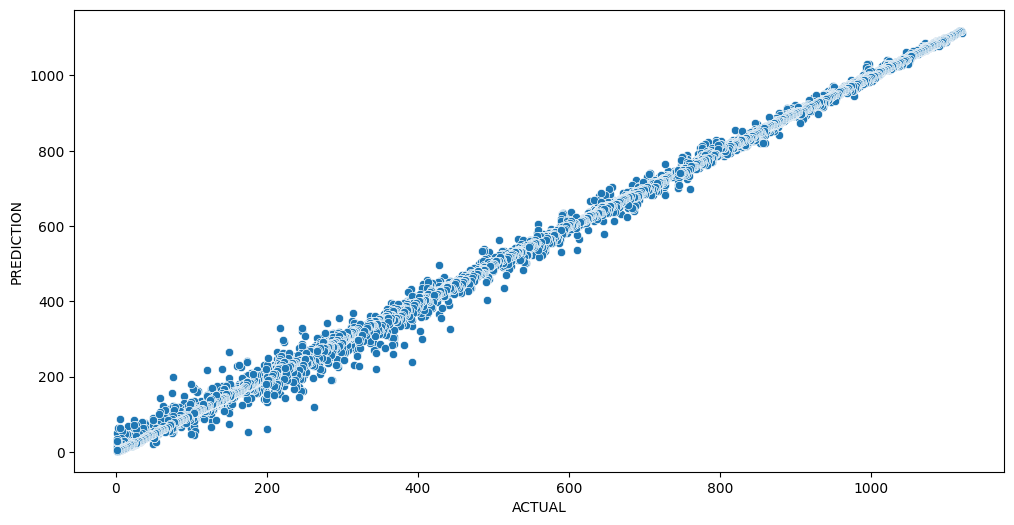

In [49]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=OUTPUT, x="ACTUAL", y="PREDICTION");

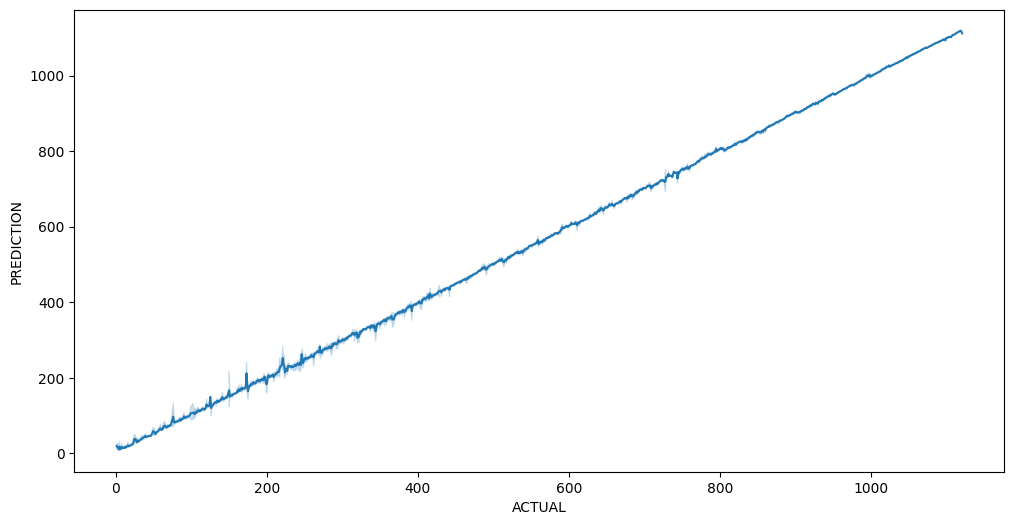

In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(data=OUTPUT, x="ACTUAL", y="PREDICTION");

<div style="background-color:#e6e6ff;text-align: center;box-shadow: rgba(0, 0, 0, 0.24) 0px 3px 8px;">
    <h2 style='padding-top:10px;padding-bottom: 10px;'>
       END
    </h2>
</div>